# Using LX-UDParser to parse sentences and displaying dependency tree graphs
This is an example notebook that illustrates how you can use the LX-UDParser web service to parse
sentences and how to visualize dependency tree graphs in a notebook.

**Before you run this example**, replace `access_key_goes_here` by your webservice access key, below:

In [1]:
LXUDPARSER_WS_API_KEY = 'access_key_goes_here'
LXUDPARSER_WS_API_URL = 'https://portulanclarin.net/workbench/lx-udparser/api/'

## Importing required Python modules
The next cell will take care of installing the `requests` and `pydependencygrapher` packages,
if not already installed, and make them available to use in this notebook.

In [2]:
try:
    import requests
except:
    !pip3 install requests
    import requests
try:
    import pydependencygrapher
except:
    # see https://github.com/pygobject/pycairo/issues/39#issuecomment-391830334
    !apt-get install libcairo2-dev libjpeg-dev libgif-dev
    !pip3 install pydependencygrapher
    import pydependencygrapher

import base64
import IPython

## Wrapping the complexities of the JSON-RPC API in a simple, easy to use function

The `WSException` class defined below, will be used later to identify errors
from the webservice.

In [3]:
class WSException(Exception):
    'Webservice Exception'
    def __init__(self, errordata):
        "errordata is a dict returned by the webservice with details about the error"
        super().__init__(self)
        assert isinstance(errordata, dict)
        self.message = errordata["message"]
        # see https://json-rpc.readthedocs.io/en/latest/exceptions.html for more info
        # about JSON-RPC error codes
        if -32099 <= errordata["code"] <= -32000:  # Server Error
            if errordata["data"]["type"] == "WebServiceException":
                self.message += f": {errordata['data']['message']}"
            else:
                self.message += f": {errordata['data']!r}"
    def __str__(self):
        return self.message

The next function invoques the LX-UDParser webservice through it's public JSON-RPC API.

In [4]:
def parse(text, format):
    '''
    Arguments
        text: a string with a maximum of 2000 characters, Portuguese text, with
             the input to be processed
        format: either 'CONLL' or 'JSON'

    Returns a string with the output according to specification in
       https://portulanclarin.net/workbench/lx-udparser/
    
    Raises a WSException if an error occurs.
    '''

    request_data = {
        'method': 'parse',
        'jsonrpc': '2.0',
        'id': 0,
        'params': {
            'text': text,
            'format': format,
            'key': LXUDPARSER_WS_API_KEY,
        },
    }
    request = requests.post(LXUDPARSER_WS_API_URL, json=request_data)
    response_data = request.json()
    if "error" in response_data:
        raise WSException(response_data["error"])
    else:
        return response_data["result"]

Let us test the function we just defined:

In [5]:
text = '''Esta frase serve para testar o funcionamento do parser de dependências. Esta outra
frase faz o mesmo.'''
# the CONLL annotation format is a popular format for annotating part of speech
# and dependency tree graphs
result = parse(text, format="CONLL")
print(result)

#id	form	lemma	cpos	pos	feat	head	deprel	phead	pdeprel
1	Esta	-	DEM	DEM	fs	2	SP	2	SP
2	frase	FRASE	CN	CN	fs	3	SJ	3	SJ
3	serve	SERVIR	V	V	pi-3s	0	ROOT	0	ROOT
4	para	-	PREP	PREP	-	3	C	3	C
5	testar	TESTAR	V	V	INF-nInf	3	COORD	3	COORD
6	o	-	DA	DA	ms	7	SP	7	SP
7	funcionamento	FUNCIONAMENTO	CN	CN	ms	5	DO	5	DO
8	de_	-	PREP	PREP	-	7	OBL	7	OBL
9	o	-	DA	DA	ms	10	SP	10	SP
10	parser	PARSER	CN	CN	ms	8	C	8	C
11	de	-	PREP	PREP	-	10	M	10	M
12	dependências	DEPENDÊNCIA	CN	CN	fp	11	C	11	C
13	.	-	PNT	PNT	-	3	PUNCT	3	PUNCT


#id	form	lemma	cpos	pos	feat	head	deprel	phead	pdeprel
1	Esta	-	DEM	DEM	fs	3	SP	3	SP
2	outra	OUTRO	ADJ	ADJ	fs	3	SP	3	SP
3	frase	FRASE	CN	CN	fs	4	SJ	4	SJ
4	faz	FAZER	V	V	pi-3s	0	ROOT	0	ROOT
5	o	-	LDEM1	LDEM1	-	4	DO	4	DO
6	mesmo	-	LDEM2	LDEM2	-	4	DO	4	DO
7	.	-	PNT	PNT	-	4	PUNCT	4	PUNCT




## Displaying dependency tree graphs from parsed text in CONLL format

To view dependency tree graphs for the parsed sentences, first we will split the CONLL output on empty lines to get one set of lines per sentence (each line carrying information pertaining to each token).

In [6]:
def group_sentence_conll_lines(conll_lines):
    """Groups CONLL-encoded lines (one line encodes one token), according to sentences.

    This generator function takes as argument a sequence of CONLL lines, and generates
    a sequence of lists, each one containing the CONLL lines of a sentence
    """
    parsed_sentences = []
    current_sentence = []
    for line in conll_lines:
        # lines starting with # are comments; ignore
        if line.startswith("#"):
            continue
        # one or more consecutive empty lines mark the end of a sentence
        if not line:
            if current_sentence:
                parsed_sentences.append(current_sentence)
                current_sentence = []
        else:
            current_sentence.append(line)
    if current_sentence:
        parsed_sentences.append(current_sentence)
    return parsed_sentences

Let us define a function `render_tree` that displays a sentence dependency graph, making use of the `pydependencygrapher` package for rendering the graph into an image and the `IPython` package for displaying the resulting image.

We also define a function `render_tree_from_conll` that will take a CONLL sentence (a list of CONLL-formatted lines, one for each token) and create one `pydependencygrapher.Token` object for each token, before calling `render_tree` to display the dependency graph.

In [7]:
def render_tree(sentence):
    graph = pydependencygrapher.DependencyGraph(sentence)
    graph.draw()
    b64png = graph.save_buffer()
    IPython.display.display(IPython.display.Image(data=base64.b64decode(b64png)))

def render_tree_from_conll(conll_sentence):
    sentence = [pydependencygrapher.Token(*conll_token.split("\t")) for conll_token in conll_sentence] 
    return render_tree(sentence)

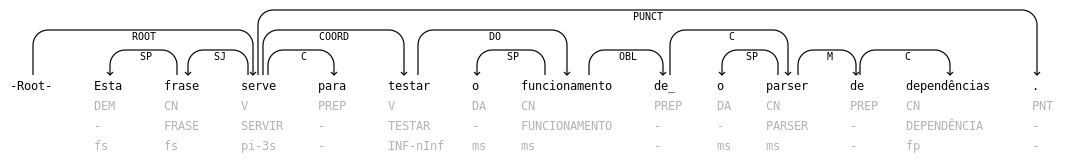

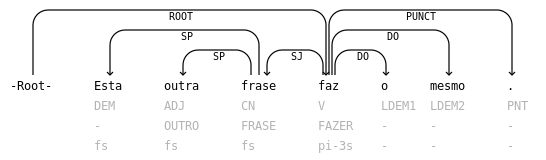

In [8]:
conll_lines = result.splitlines(keepends=False)
for conll_sentence in group_sentence_conll_lines(conll_lines):
    data = render_tree_from_conll(conll_sentence)

## The JSON output format

The JSON format (which we obtain by passing `format="JSON"` into the `parse` function) is more
convenient when we need to further process the annotations, because each abstraction is mapped
directly into a Python native object (lists, dicts, strings, etc) as follows:
- The returned object is a `list`, where each element corresponds to a paragraph of the given text;
- In turn, each paragraph is a `list` where each element represents a sentence;
- Each sentence is a `list` where each element represents a token;
- Each token is a `dict` where each key-value pair is an attribute of the token.

In [9]:
parsed_text = parse(text, tagset="CINTIL", format="JSON")
for pnum, paragraph in enumerate(parsed_text, start=1): # enumerate paragraphs in text, starting at 1
    print(f"paragraph {pnum}:")
    for snum, sentence in enumerate(paragraph, start=1): # enumerate sentences in paragraph, starting at 1
        print(f"  sentence {snum}:")
        for tnum, token in enumerate(sentence, start=1): # enumerate tokens in sentence, starting at 1
            print(f"    token {tnum}: {token!r}")  # print a token representation

paragraph 1:
  sentence 1:
    token 1: {'form': 'Esta', 'space': 'LR', 'pos': 'DEM', 'infl': 'fs', 'deprel': 'SP', 'parent': 2}
    token 2: {'form': 'frase', 'space': 'LR', 'pos': 'CN', 'lemma': 'FRASE', 'infl': 'fs', 'deprel': 'SJ', 'parent': 3}
    token 3: {'form': 'serve', 'space': 'LR', 'pos': 'V', 'lemma': 'SERVIR', 'infl': 'pi-3s', 'deprel': 'ROOT', 'parent': 0}
    token 4: {'form': 'para', 'space': 'LR', 'pos': 'PREP', 'deprel': 'C', 'parent': 3}
    token 5: {'form': 'testar', 'space': 'LR', 'pos': 'V', 'lemma': 'TESTAR', 'infl': 'INF-nInf', 'deprel': 'COORD', 'parent': 3}
    token 6: {'form': 'o', 'space': 'LR', 'pos': 'DA', 'infl': 'ms', 'deprel': 'SP', 'parent': 7}
    token 7: {'form': 'funcionamento', 'space': 'LR', 'pos': 'CN', 'lemma': 'FUNCIONAMENTO', 'infl': 'ms', 'deprel': 'DO', 'parent': 5}
    token 8: {'form': 'de_', 'space': 'L', 'raw': 'do', 'pos': 'PREP', 'deprel': 'OBL', 'parent': 7}
    token 9: {'form': 'o', 'space': 'R', 'pos': 'DA', 'infl': 'ms', 'depr

## Displaying dependency graphs from parsed text in JSON format
Let us define a function, similar to `render_tree_from_conll` to display dependency graphs for JSON-encoded sentences.

In [10]:
def render_tree_from_json(json_sentence):
    token_attributes = ["form", "lemma", "upos", "upos", "ufeats", "uparent", "udeprel", "uparent", "udeprel"]
    sentence = []
    for num, token in enumerate(json_sentence, start=1):
        sentence.append(
            pydependencygrapher.Token(
                num,
                *[token.get(attribute, "_") for attribute in token_attributes]
            )
        )
    return render_tree(sentence)

Let us test the function we just defined

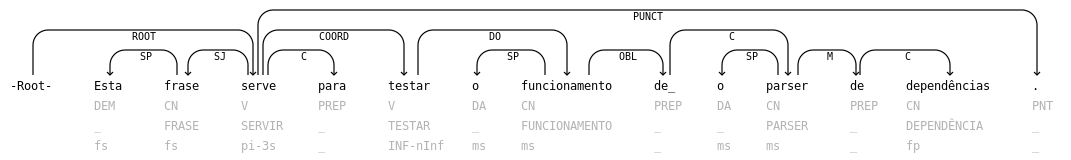

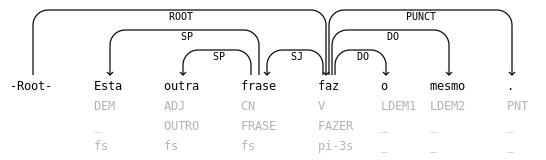

In [11]:
for paragraph in parsed_text:
    for sentence in paragraph:
        render_tree_from_json(sentence)

## Getting the status of a webservice access key

In [12]:
def get_key_status():
    '''Returns a string with the detailed status of the webservice access key'''
    
    request_data = {
        'method': 'key_status',
        'jsonrpc': '2.0',
        'id': 0,
        'params': {
            'key': LXUDPARSER_WS_API_KEY,
        },
    }
    request = requests.post(LXUDPARSER_WS_API_URL, json=request_data)
    response_data = request.json()
    if "error" in response_data:
        raise WSException(response_data["error"])
    else:
        return response_data["result"]

In [13]:
get_key_status()

{'requests_remaining': 99999970,
 'chars_remaining': 999998849,
 'expiry': '2030-01-10T00:00+00:00'}